# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [2]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for idx, (data, target) in enumerate(train_loader):
        data = data.float()
        
        if use_cuda == True:
            target = target.cuda()
            data = data.cuda()
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        
        # TODO: run the network
        prediction = model(data)
        prediction = prediction.squeeze()
        
        # TODO: compute negative log likelihood loss
        neg_log_likelihood = F.nll_loss(prediction, target)
        
        
        # TODO: do backpropagation
        neg_log_likelihood.backward()
       
        
        # TODO: optimize
        optimizer.step()
       
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if idx % log_interval == 0:
            print(neg_log_likelihood)
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            output = output.squeeze()
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        layers = []
        layers.append(nn.Linear(784, 200))
        layers.append(nn.Sigmoid())
        layers.append(nn.Linear(200, 100))
        layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 60))
        layers.append(nn.Sigmoid())
        layers.append(nn.Linear(60, 30))
        layers.append(nn.Sigmoid())
        layers.append(nn.Linear(30, 10))
        layers.append(nn.Sigmoid())
        
        self.linear_layer= nn.Sequential(*layers)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(start_dim=2, end_dim=-1)
        x = x.squeeze()
        
        # TODO: run network layers
        prediction = self.linear_layer(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(prediction)
        
        
        return output

In [5]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with ReLU non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet2, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        layers = []
        layers.append(nn.Linear(784, 200))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(200, 100))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(100, 60))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(60, 30))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(30, 10))
        layers.append(nn.ReLU())
        
        self.linear_layer= nn.Sequential(*layers)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(start_dim=2, end_dim=-1)
        x = x.squeeze()
        
        # TODO: run network layers
        prediction = self.linear_layer(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(prediction)
        
        
        return output

In [6]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with ReLU non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet3, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        layers = []
        layers.append(nn.Linear(784, 200))
        layers.append(nn.BatchNorm1d(200))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(200, 100))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(100, 60))
        layers.append(nn.BatchNorm1d(60))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(60, 30))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(30, 10))
        layers.append(nn.ReLU())
        
        self.linear_layer= nn.Sequential(*layers)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(start_dim=2, end_dim=-1)
        x = x.squeeze()
        
        # TODO: run network layers
        prediction = self.linear_layer(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(prediction)
        
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [7]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        conv_layers = []
        linear_layers = []
        conv_layers.append(nn.Conv2d(1, 32, kernel_size=3))
        conv_layers.append(nn.ReLU())
        conv_layers.append(nn.Conv2d(32, 64, kernel_size=3, stride=2))
        conv_layers.append(nn.ReLU())
        
        linear_layers.append(nn.Linear(9216, 128))
        linear_layers.append(nn.ReLU())
        linear_layers.append(nn.Linear(128, 10))
        self.conv_layer = nn.Sequential(*conv_layers)
        self.linear_layer = nn.Sequential(*linear_layers)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv_layer(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(start_dim=1, end_dim=-1)
        
        
        # TODO: run fully connected layers
        x = self.linear_layer(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        return output

In [8]:
class ConvNet2(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # TODO: initialize network layers
        conv_layers = []
        linear_layers = []
        conv_layers.append(nn.Conv2d(1, 32, kernel_size=3))
        conv_layers.append(nn.BatchNorm2d(32))
        conv_layers.append(nn.ReLU())
        conv_layers.append(nn.Conv2d(32, 64, kernel_size=3, stride = 2))
        conv_layers.append(nn.ReLU())
    
        linear_layers.append(nn.Linear(9216, 128))
        linear_layers.append(nn.BatchNorm1d(128))
        linear_layers.append(nn.ReLU())
        linear_layers.append(nn.Linear(128, 10))
        self.conv_layer = nn.Sequential(*conv_layers)
        self.linear_layer = nn.Sequential(*linear_layers)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv_layer(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(start_dim=1, end_dim=-1)
        
        
        # TODO: run fully connected layers
        x = self.linear_layer(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        return output

In [9]:
class ConvNet3(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        # TODO: initialize network layers
        conv_layers = []
        linear_layers = []
        conv_layers.append(nn.Conv2d(1, 32, kernel_size=3))
        conv_layers.append(nn.BatchNorm2d(32))
        conv_layers.append(nn.ReLU())
        conv_layers.append(nn.Conv2d(32, 64, kernel_size=3))
        conv_layers.append(nn.ReLU())
        conv_layers.append(nn.MaxPool2d(2))
        
        linear_layers.append(nn.Linear(9216, 128))
        linear_layers.append(nn.BatchNorm1d(128))
        linear_layers.append(nn.ReLU())
        linear_layers.append(nn.Linear(128, 10))
        self.conv_layer = nn.Sequential(*conv_layers)
        self.linear_layer = nn.Sequential(*linear_layers)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv_layer(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(start_dim=1, end_dim=-1)
        
        
        # TODO: run fully connected layers
        x = self.linear_layer(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        return output

In [10]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

/var/folders/c6/t8mdrkg55qn7fgh__gkv7nlc0000gn/T/ipykernel_22059/2905837818.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(prediction)


tensor(2.3114, grad_fn=<NllLossBackward0>)
tensor(2.3024, grad_fn=<NllLossBackward0>)
tensor(2.3109, grad_fn=<NllLossBackward0>)
tensor(2.3019, grad_fn=<NllLossBackward0>)
tensor(2.2909, grad_fn=<NllLossBackward0>)
tensor(2.3009, grad_fn=<NllLossBackward0>)
tensor(2.3016, grad_fn=<NllLossBackward0>)
tensor(2.2915, grad_fn=<NllLossBackward0>)
tensor(2.3014, grad_fn=<NllLossBackward0>)
tensor(2.2996, grad_fn=<NllLossBackward0>)

Test set: Average loss: 2.3017, Accuracy: 1135/10000 (11.35%)



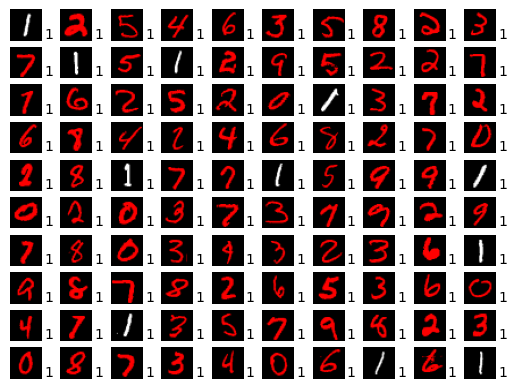

tensor(2.2957, grad_fn=<NllLossBackward0>)
tensor(2.3024, grad_fn=<NllLossBackward0>)
tensor(2.2912, grad_fn=<NllLossBackward0>)
tensor(2.2965, grad_fn=<NllLossBackward0>)
tensor(2.2993, grad_fn=<NllLossBackward0>)
tensor(2.2867, grad_fn=<NllLossBackward0>)
tensor(2.3088, grad_fn=<NllLossBackward0>)
tensor(2.3110, grad_fn=<NllLossBackward0>)
tensor(2.2966, grad_fn=<NllLossBackward0>)
tensor(2.3010, grad_fn=<NllLossBackward0>)

Test set: Average loss: 2.3017, Accuracy: 1135/10000 (11.35%)



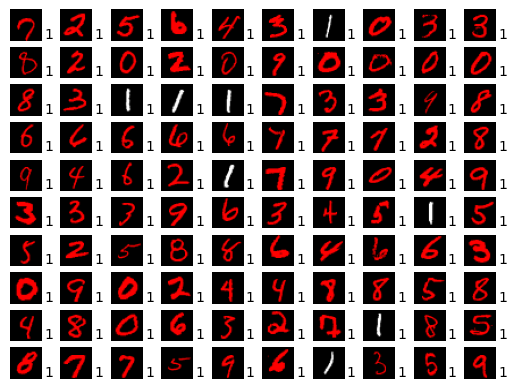

tensor(2.3030, grad_fn=<NllLossBackward0>)
tensor(2.3099, grad_fn=<NllLossBackward0>)
tensor(2.3148, grad_fn=<NllLossBackward0>)
tensor(2.2989, grad_fn=<NllLossBackward0>)
tensor(2.2994, grad_fn=<NllLossBackward0>)
tensor(2.2906, grad_fn=<NllLossBackward0>)
tensor(2.2984, grad_fn=<NllLossBackward0>)
tensor(2.3033, grad_fn=<NllLossBackward0>)
tensor(2.2941, grad_fn=<NllLossBackward0>)
tensor(2.3061, grad_fn=<NllLossBackward0>)

Test set: Average loss: 2.3005, Accuracy: 1135/10000 (11.35%)



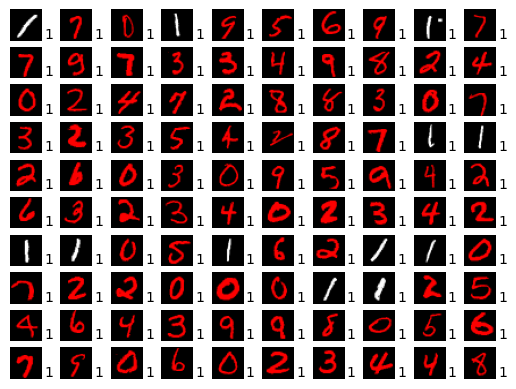

tensor(2.2999, grad_fn=<NllLossBackward0>)
tensor(2.2990, grad_fn=<NllLossBackward0>)
tensor(2.3179, grad_fn=<NllLossBackward0>)
tensor(2.3035, grad_fn=<NllLossBackward0>)
tensor(2.3098, grad_fn=<NllLossBackward0>)
tensor(2.2984, grad_fn=<NllLossBackward0>)
tensor(2.2998, grad_fn=<NllLossBackward0>)
tensor(2.3011, grad_fn=<NllLossBackward0>)
tensor(2.2934, grad_fn=<NllLossBackward0>)
tensor(2.3050, grad_fn=<NllLossBackward0>)

Test set: Average loss: 2.2991, Accuracy: 1135/10000 (11.35%)



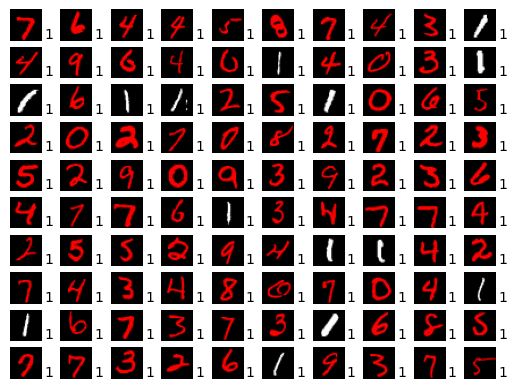

tensor(2.2977, grad_fn=<NllLossBackward0>)
tensor(2.3032, grad_fn=<NllLossBackward0>)
tensor(2.3041, grad_fn=<NllLossBackward0>)
tensor(2.2871, grad_fn=<NllLossBackward0>)
tensor(2.2993, grad_fn=<NllLossBackward0>)
tensor(2.3021, grad_fn=<NllLossBackward0>)
tensor(2.2889, grad_fn=<NllLossBackward0>)
tensor(2.2805, grad_fn=<NllLossBackward0>)
tensor(2.3049, grad_fn=<NllLossBackward0>)
tensor(2.2758, grad_fn=<NllLossBackward0>)

Test set: Average loss: 2.2757, Accuracy: 1679/10000 (16.79%)



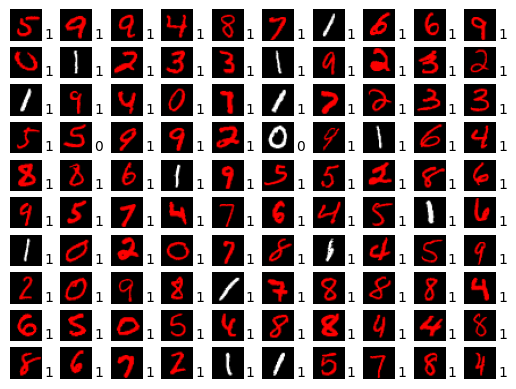

tensor(2.2709, grad_fn=<NllLossBackward0>)
tensor(2.2728, grad_fn=<NllLossBackward0>)
tensor(2.2542, grad_fn=<NllLossBackward0>)
tensor(2.2181, grad_fn=<NllLossBackward0>)
tensor(2.1736, grad_fn=<NllLossBackward0>)
tensor(2.1343, grad_fn=<NllLossBackward0>)
tensor(2.1265, grad_fn=<NllLossBackward0>)
tensor(2.0814, grad_fn=<NllLossBackward0>)
tensor(2.0485, grad_fn=<NllLossBackward0>)
tensor(2.0560, grad_fn=<NllLossBackward0>)

Test set: Average loss: 2.0483, Accuracy: 2095/10000 (20.95%)



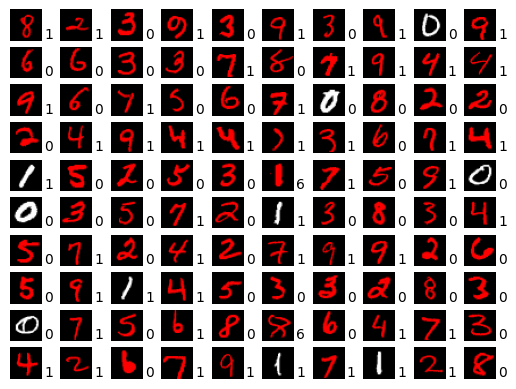

tensor(2.0470, grad_fn=<NllLossBackward0>)
tensor(2.0457, grad_fn=<NllLossBackward0>)
tensor(2.0421, grad_fn=<NllLossBackward0>)
tensor(2.0013, grad_fn=<NllLossBackward0>)
tensor(2.0252, grad_fn=<NllLossBackward0>)
tensor(1.9898, grad_fn=<NllLossBackward0>)
tensor(2.0402, grad_fn=<NllLossBackward0>)
tensor(2.0334, grad_fn=<NllLossBackward0>)
tensor(2.0064, grad_fn=<NllLossBackward0>)
tensor(2.0006, grad_fn=<NllLossBackward0>)

Test set: Average loss: 2.0014, Accuracy: 2022/10000 (20.22%)



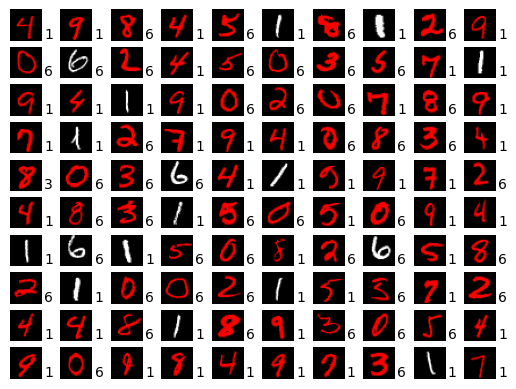

tensor(2.0140, grad_fn=<NllLossBackward0>)
tensor(1.9820, grad_fn=<NllLossBackward0>)
tensor(2.0017, grad_fn=<NllLossBackward0>)
tensor(2.0007, grad_fn=<NllLossBackward0>)
tensor(2.0506, grad_fn=<NllLossBackward0>)
tensor(1.9765, grad_fn=<NllLossBackward0>)
tensor(1.9675, grad_fn=<NllLossBackward0>)
tensor(2.0195, grad_fn=<NllLossBackward0>)
tensor(1.9609, grad_fn=<NllLossBackward0>)
tensor(2.0349, grad_fn=<NllLossBackward0>)

Test set: Average loss: 1.9890, Accuracy: 2040/10000 (20.40%)



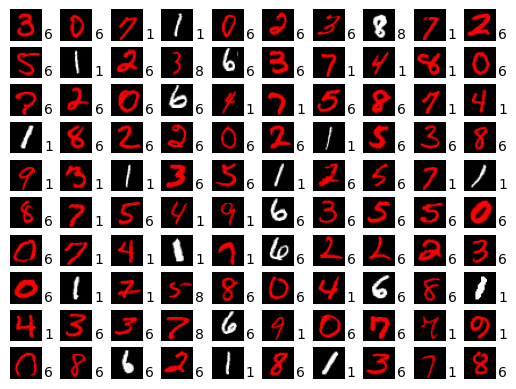

tensor(2.0068, grad_fn=<NllLossBackward0>)
tensor(1.9617, grad_fn=<NllLossBackward0>)
tensor(1.9466, grad_fn=<NllLossBackward0>)
tensor(1.9452, grad_fn=<NllLossBackward0>)
tensor(2.0082, grad_fn=<NllLossBackward0>)
tensor(1.9716, grad_fn=<NllLossBackward0>)
tensor(1.9846, grad_fn=<NllLossBackward0>)
tensor(1.9652, grad_fn=<NllLossBackward0>)
tensor(1.9676, grad_fn=<NllLossBackward0>)
tensor(2.0013, grad_fn=<NllLossBackward0>)

Test set: Average loss: 1.9840, Accuracy: 2098/10000 (20.98%)



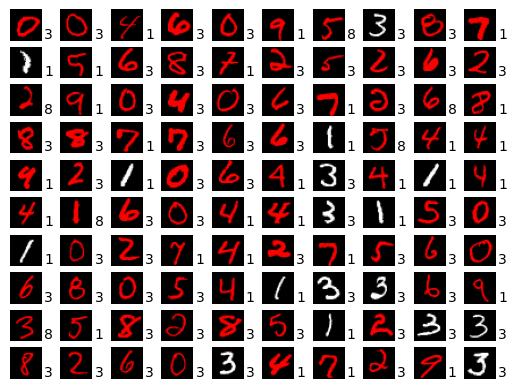

tensor(1.9758, grad_fn=<NllLossBackward0>)
tensor(1.9947, grad_fn=<NllLossBackward0>)
tensor(1.9740, grad_fn=<NllLossBackward0>)
tensor(2.0082, grad_fn=<NllLossBackward0>)
tensor(1.9888, grad_fn=<NllLossBackward0>)
tensor(1.9494, grad_fn=<NllLossBackward0>)
tensor(1.9615, grad_fn=<NllLossBackward0>)
tensor(1.9963, grad_fn=<NllLossBackward0>)
tensor(1.9766, grad_fn=<NllLossBackward0>)
tensor(1.9500, grad_fn=<NllLossBackward0>)

Test set: Average loss: 1.9816, Accuracy: 2111/10000 (21.11%)



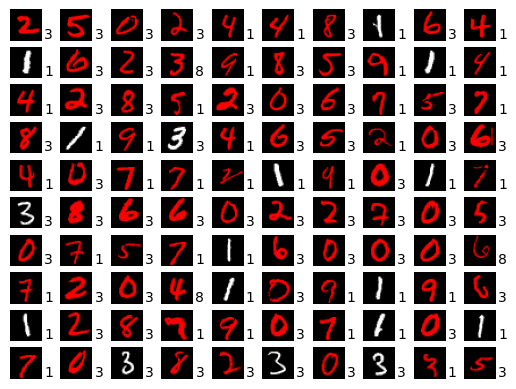

In [11]:
model = FCNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler

optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint_FCNet1.pt")

/var/folders/c6/t8mdrkg55qn7fgh__gkv7nlc0000gn/T/ipykernel_22059/1226363665.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(prediction)


tensor(2.2989, grad_fn=<NllLossBackward0>)
tensor(1.0313, grad_fn=<NllLossBackward0>)
tensor(0.9693, grad_fn=<NllLossBackward0>)
tensor(0.9685, grad_fn=<NllLossBackward0>)
tensor(0.8042, grad_fn=<NllLossBackward0>)
tensor(0.9968, grad_fn=<NllLossBackward0>)
tensor(1.1753, grad_fn=<NllLossBackward0>)
tensor(0.7698, grad_fn=<NllLossBackward0>)
tensor(0.8447, grad_fn=<NllLossBackward0>)
tensor(0.9356, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.8050, Accuracy: 6766/10000 (67.66%)



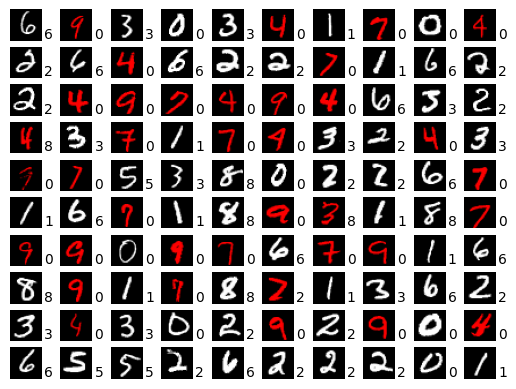

tensor(0.6476, grad_fn=<NllLossBackward0>)
tensor(0.5523, grad_fn=<NllLossBackward0>)
tensor(0.8580, grad_fn=<NllLossBackward0>)
tensor(0.8812, grad_fn=<NllLossBackward0>)
tensor(0.7741, grad_fn=<NllLossBackward0>)
tensor(0.7012, grad_fn=<NllLossBackward0>)
tensor(0.8054, grad_fn=<NllLossBackward0>)
tensor(0.6044, grad_fn=<NllLossBackward0>)
tensor(0.6452, grad_fn=<NllLossBackward0>)
tensor(0.9399, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.7595, Accuracy: 6843/10000 (68.43%)



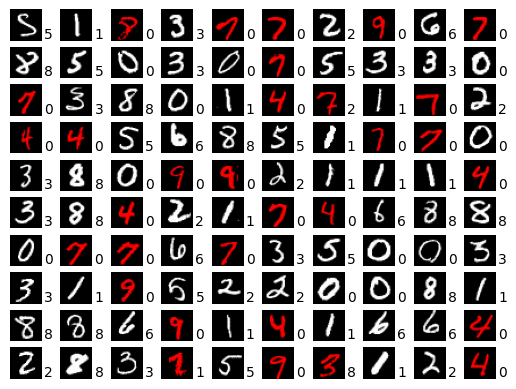

tensor(0.7304, grad_fn=<NllLossBackward0>)
tensor(0.8534, grad_fn=<NllLossBackward0>)
tensor(0.6481, grad_fn=<NllLossBackward0>)
tensor(0.5861, grad_fn=<NllLossBackward0>)
tensor(0.8011, grad_fn=<NllLossBackward0>)
tensor(0.9024, grad_fn=<NllLossBackward0>)
tensor(0.7101, grad_fn=<NllLossBackward0>)
tensor(0.4333, grad_fn=<NllLossBackward0>)
tensor(0.7684, grad_fn=<NllLossBackward0>)
tensor(0.6591, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.7562, Accuracy: 6864/10000 (68.64%)



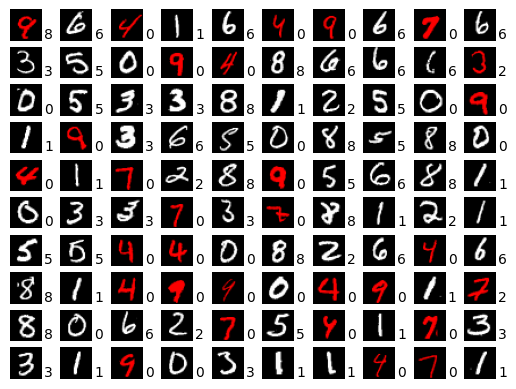

tensor(0.6783, grad_fn=<NllLossBackward0>)
tensor(0.7354, grad_fn=<NllLossBackward0>)
tensor(0.8334, grad_fn=<NllLossBackward0>)
tensor(0.8810, grad_fn=<NllLossBackward0>)
tensor(0.5401, grad_fn=<NllLossBackward0>)
tensor(0.8042, grad_fn=<NllLossBackward0>)
tensor(0.8069, grad_fn=<NllLossBackward0>)
tensor(0.9360, grad_fn=<NllLossBackward0>)
tensor(0.5989, grad_fn=<NllLossBackward0>)
tensor(0.8700, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.7519, Accuracy: 6867/10000 (68.67%)



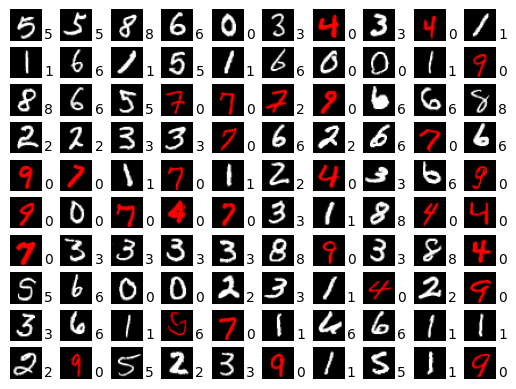

tensor(0.6842, grad_fn=<NllLossBackward0>)
tensor(0.9134, grad_fn=<NllLossBackward0>)
tensor(0.5038, grad_fn=<NllLossBackward0>)
tensor(0.7350, grad_fn=<NllLossBackward0>)
tensor(0.8321, grad_fn=<NllLossBackward0>)
tensor(0.4035, grad_fn=<NllLossBackward0>)
tensor(0.5497, grad_fn=<NllLossBackward0>)
tensor(0.9077, grad_fn=<NllLossBackward0>)
tensor(0.4327, grad_fn=<NllLossBackward0>)
tensor(0.5452, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.7527, Accuracy: 6874/10000 (68.74%)



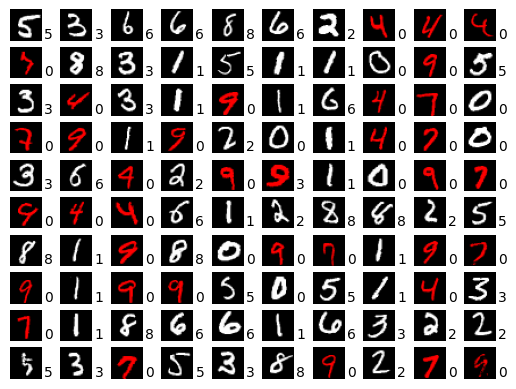

tensor(0.9021, grad_fn=<NllLossBackward0>)
tensor(0.7099, grad_fn=<NllLossBackward0>)
tensor(0.7917, grad_fn=<NllLossBackward0>)
tensor(0.4324, grad_fn=<NllLossBackward0>)
tensor(0.5757, grad_fn=<NllLossBackward0>)
tensor(0.7200, grad_fn=<NllLossBackward0>)
tensor(0.9018, grad_fn=<NllLossBackward0>)
tensor(0.8682, grad_fn=<NllLossBackward0>)
tensor(0.5771, grad_fn=<NllLossBackward0>)
tensor(0.6122, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.7534, Accuracy: 6876/10000 (68.76%)



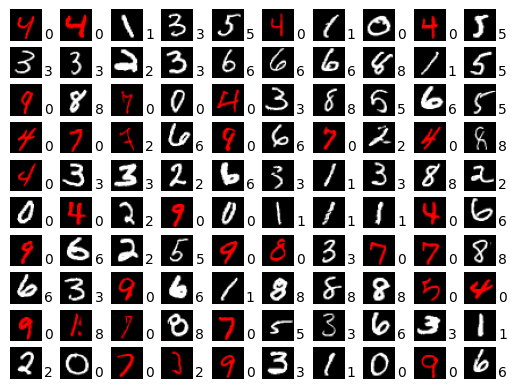

tensor(0.6846, grad_fn=<NllLossBackward0>)
tensor(0.7248, grad_fn=<NllLossBackward0>)
tensor(0.7246, grad_fn=<NllLossBackward0>)
tensor(0.7197, grad_fn=<NllLossBackward0>)
tensor(0.7262, grad_fn=<NllLossBackward0>)
tensor(0.6120, grad_fn=<NllLossBackward0>)
tensor(0.8315, grad_fn=<NllLossBackward0>)
tensor(0.7556, grad_fn=<NllLossBackward0>)
tensor(0.7561, grad_fn=<NllLossBackward0>)
tensor(0.8711, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.7568, Accuracy: 6882/10000 (68.82%)



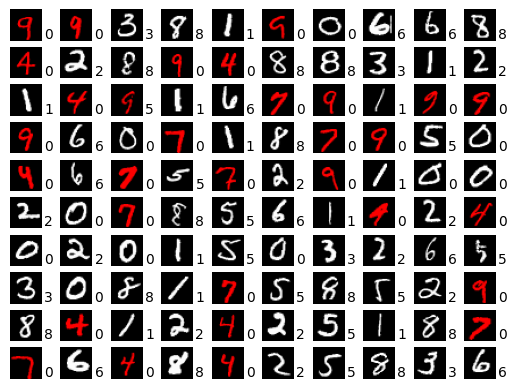

tensor(0.5919, grad_fn=<NllLossBackward0>)
tensor(0.8279, grad_fn=<NllLossBackward0>)
tensor(1.0156, grad_fn=<NllLossBackward0>)
tensor(0.8661, grad_fn=<NllLossBackward0>)
tensor(0.6840, grad_fn=<NllLossBackward0>)
tensor(0.6488, grad_fn=<NllLossBackward0>)
tensor(0.7557, grad_fn=<NllLossBackward0>)
tensor(0.9389, grad_fn=<NllLossBackward0>)
tensor(0.7919, grad_fn=<NllLossBackward0>)
tensor(0.6126, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.7588, Accuracy: 6876/10000 (68.76%)



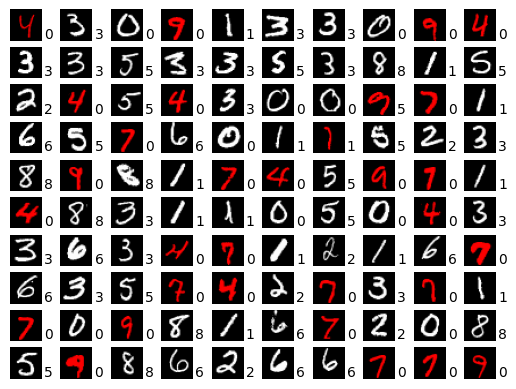

tensor(0.8295, grad_fn=<NllLossBackward0>)
tensor(0.5777, grad_fn=<NllLossBackward0>)
tensor(0.4810, grad_fn=<NllLossBackward0>)
tensor(0.6876, grad_fn=<NllLossBackward0>)
tensor(0.6477, grad_fn=<NllLossBackward0>)
tensor(0.5397, grad_fn=<NllLossBackward0>)
tensor(0.6476, grad_fn=<NllLossBackward0>)
tensor(0.5425, grad_fn=<NllLossBackward0>)
tensor(0.6307, grad_fn=<NllLossBackward0>)
tensor(0.8302, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.7602, Accuracy: 6880/10000 (68.80%)



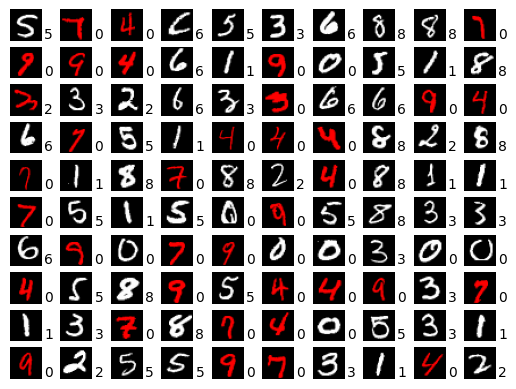

tensor(0.5758, grad_fn=<NllLossBackward0>)
tensor(0.9402, grad_fn=<NllLossBackward0>)
tensor(0.7942, grad_fn=<NllLossBackward0>)
tensor(0.5402, grad_fn=<NllLossBackward0>)
tensor(0.5862, grad_fn=<NllLossBackward0>)
tensor(0.5771, grad_fn=<NllLossBackward0>)
tensor(0.6486, grad_fn=<NllLossBackward0>)
tensor(0.6122, grad_fn=<NllLossBackward0>)
tensor(0.7561, grad_fn=<NllLossBackward0>)
tensor(0.9718, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.7600, Accuracy: 6878/10000 (68.78%)



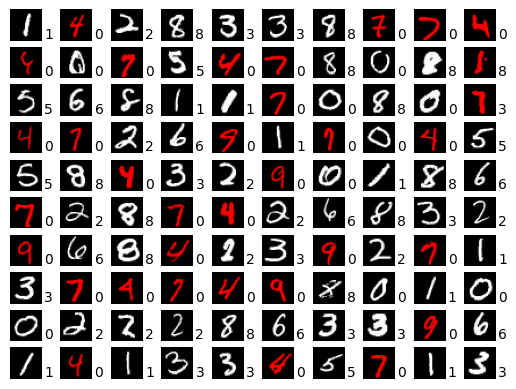

In [12]:
model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler

optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint_FCNet2.pt")

/var/folders/c6/t8mdrkg55qn7fgh__gkv7nlc0000gn/T/ipykernel_22059/3760245623.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(prediction)


tensor(2.2999, grad_fn=<NllLossBackward0>)
tensor(0.8689, grad_fn=<NllLossBackward0>)
tensor(0.4996, grad_fn=<NllLossBackward0>)
tensor(0.7151, grad_fn=<NllLossBackward0>)
tensor(0.5488, grad_fn=<NllLossBackward0>)
tensor(0.6271, grad_fn=<NllLossBackward0>)
tensor(0.5678, grad_fn=<NllLossBackward0>)
tensor(0.4606, grad_fn=<NllLossBackward0>)
tensor(0.4433, grad_fn=<NllLossBackward0>)
tensor(0.4636, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.6009, Accuracy: 7618/10000 (76.18%)



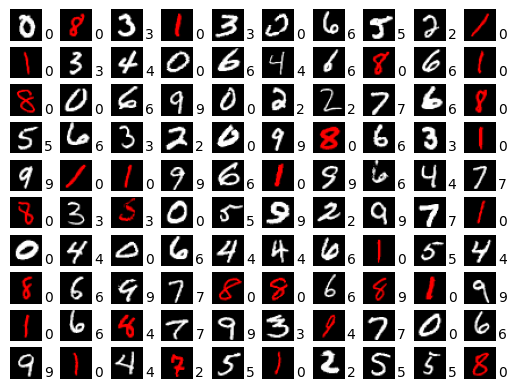

tensor(0.5978, grad_fn=<NllLossBackward0>)
tensor(0.4718, grad_fn=<NllLossBackward0>)
tensor(0.3746, grad_fn=<NllLossBackward0>)
tensor(0.4610, grad_fn=<NllLossBackward0>)
tensor(0.3136, grad_fn=<NllLossBackward0>)
tensor(0.5102, grad_fn=<NllLossBackward0>)
tensor(0.6409, grad_fn=<NllLossBackward0>)
tensor(0.6503, grad_fn=<NllLossBackward0>)
tensor(0.5086, grad_fn=<NllLossBackward0>)
tensor(0.5239, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.5580, Accuracy: 7724/10000 (77.24%)



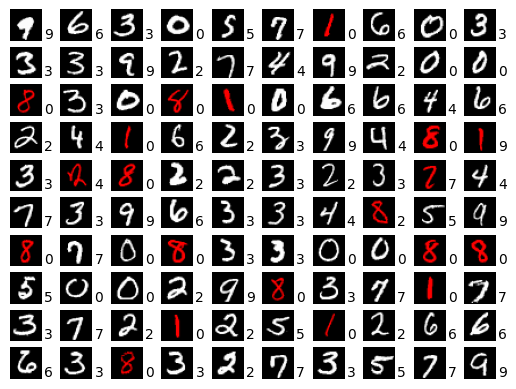

tensor(0.3403, grad_fn=<NllLossBackward0>)
tensor(0.3249, grad_fn=<NllLossBackward0>)
tensor(0.7049, grad_fn=<NllLossBackward0>)
tensor(0.6831, grad_fn=<NllLossBackward0>)
tensor(0.4813, grad_fn=<NllLossBackward0>)
tensor(0.7131, grad_fn=<NllLossBackward0>)
tensor(0.3235, grad_fn=<NllLossBackward0>)
tensor(0.5622, grad_fn=<NllLossBackward0>)
tensor(0.3174, grad_fn=<NllLossBackward0>)
tensor(0.6529, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.5508, Accuracy: 7762/10000 (77.62%)



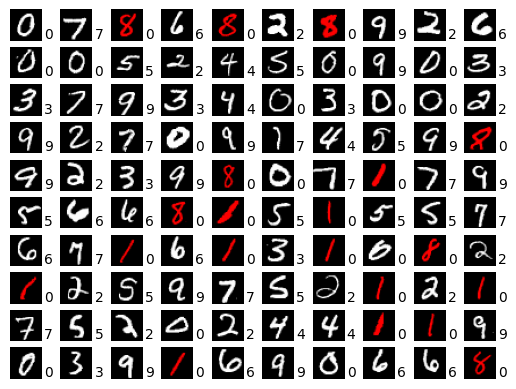

tensor(0.5999, grad_fn=<NllLossBackward0>)
tensor(0.4554, grad_fn=<NllLossBackward0>)
tensor(0.5780, grad_fn=<NllLossBackward0>)
tensor(0.4082, grad_fn=<NllLossBackward0>)
tensor(0.6168, grad_fn=<NllLossBackward0>)
tensor(0.3371, grad_fn=<NllLossBackward0>)
tensor(0.4479, grad_fn=<NllLossBackward0>)
tensor(0.4505, grad_fn=<NllLossBackward0>)
tensor(0.4244, grad_fn=<NllLossBackward0>)
tensor(0.4669, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.5475, Accuracy: 7752/10000 (77.52%)



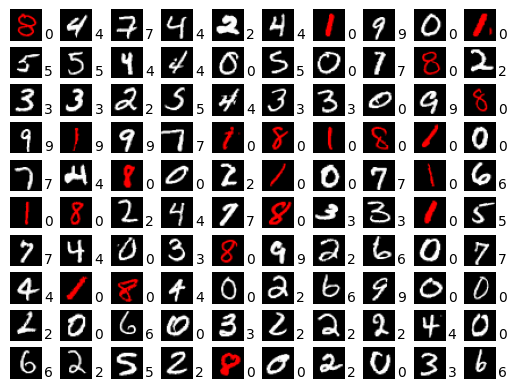

tensor(0.4933, grad_fn=<NllLossBackward0>)
tensor(0.7524, grad_fn=<NllLossBackward0>)
tensor(0.5262, grad_fn=<NllLossBackward0>)
tensor(0.4718, grad_fn=<NllLossBackward0>)
tensor(0.5832, grad_fn=<NllLossBackward0>)
tensor(0.5786, grad_fn=<NllLossBackward0>)
tensor(0.4748, grad_fn=<NllLossBackward0>)
tensor(0.4572, grad_fn=<NllLossBackward0>)
tensor(0.7264, grad_fn=<NllLossBackward0>)
tensor(0.6168, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.5415, Accuracy: 7771/10000 (77.71%)



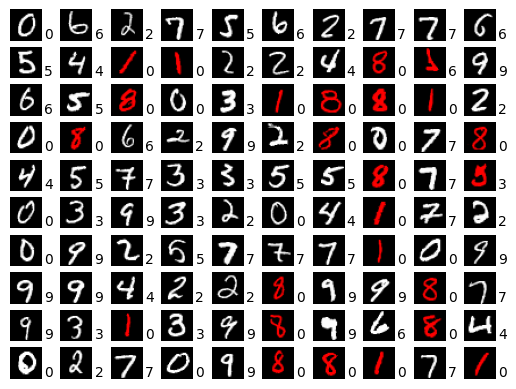

tensor(0.3387, grad_fn=<NllLossBackward0>)
tensor(0.7354, grad_fn=<NllLossBackward0>)
tensor(0.5049, grad_fn=<NllLossBackward0>)
tensor(0.4014, grad_fn=<NllLossBackward0>)
tensor(0.4688, grad_fn=<NllLossBackward0>)
tensor(0.7416, grad_fn=<NllLossBackward0>)
tensor(0.3664, grad_fn=<NllLossBackward0>)
tensor(0.4693, grad_fn=<NllLossBackward0>)
tensor(0.3766, grad_fn=<NllLossBackward0>)
tensor(0.3654, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.5409, Accuracy: 7779/10000 (77.79%)



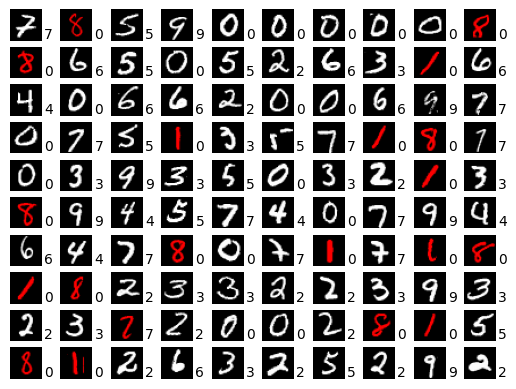

tensor(0.5280, grad_fn=<NllLossBackward0>)
tensor(0.6167, grad_fn=<NllLossBackward0>)
tensor(0.4408, grad_fn=<NllLossBackward0>)
tensor(0.5765, grad_fn=<NllLossBackward0>)
tensor(0.4691, grad_fn=<NllLossBackward0>)
tensor(0.4741, grad_fn=<NllLossBackward0>)
tensor(0.5768, grad_fn=<NllLossBackward0>)
tensor(0.5043, grad_fn=<NllLossBackward0>)
tensor(0.4734, grad_fn=<NllLossBackward0>)
tensor(0.1462, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.5397, Accuracy: 7779/10000 (77.79%)



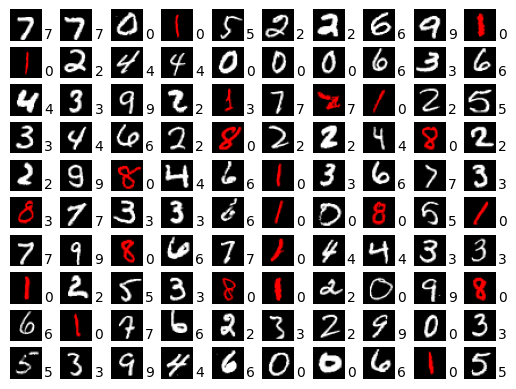

tensor(0.3637, grad_fn=<NllLossBackward0>)
tensor(0.3970, grad_fn=<NllLossBackward0>)
tensor(0.9800, grad_fn=<NllLossBackward0>)
tensor(0.4320, grad_fn=<NllLossBackward0>)
tensor(0.4429, grad_fn=<NllLossBackward0>)
tensor(0.4458, grad_fn=<NllLossBackward0>)
tensor(0.5155, grad_fn=<NllLossBackward0>)
tensor(0.5400, grad_fn=<NllLossBackward0>)
tensor(0.6962, grad_fn=<NllLossBackward0>)
tensor(0.3817, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.5415, Accuracy: 7768/10000 (77.68%)



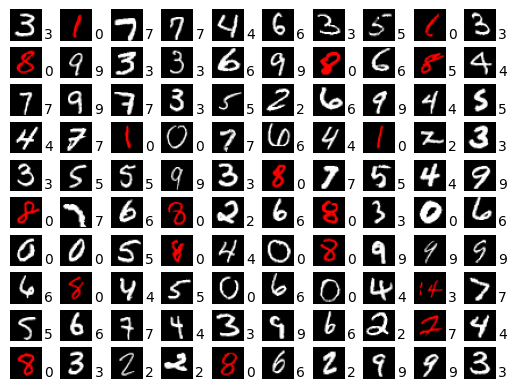

tensor(0.5123, grad_fn=<NllLossBackward0>)
tensor(0.3490, grad_fn=<NllLossBackward0>)
tensor(0.3962, grad_fn=<NllLossBackward0>)
tensor(0.5403, grad_fn=<NllLossBackward0>)
tensor(0.4639, grad_fn=<NllLossBackward0>)
tensor(0.3604, grad_fn=<NllLossBackward0>)
tensor(0.4983, grad_fn=<NllLossBackward0>)
tensor(0.5060, grad_fn=<NllLossBackward0>)
tensor(0.6549, grad_fn=<NllLossBackward0>)
tensor(0.4124, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.5403, Accuracy: 7774/10000 (77.74%)



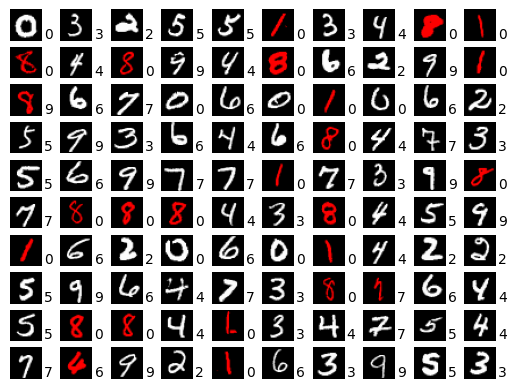

tensor(0.5020, grad_fn=<NllLossBackward0>)
tensor(0.5446, grad_fn=<NllLossBackward0>)
tensor(0.4692, grad_fn=<NllLossBackward0>)
tensor(0.3616, grad_fn=<NllLossBackward0>)
tensor(0.6129, grad_fn=<NllLossBackward0>)
tensor(0.5791, grad_fn=<NllLossBackward0>)
tensor(0.3630, grad_fn=<NllLossBackward0>)
tensor(0.6146, grad_fn=<NllLossBackward0>)
tensor(0.4694, grad_fn=<NllLossBackward0>)
tensor(0.5041, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.5396, Accuracy: 7777/10000 (77.77%)



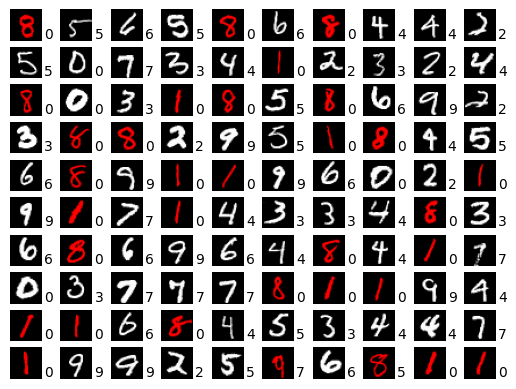

In [13]:
model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler

optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint_FCNet3.pt")

/var/folders/c6/t8mdrkg55qn7fgh__gkv7nlc0000gn/T/ipykernel_22059/3574077627.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


tensor(2.3050, grad_fn=<NllLossBackward0>)
tensor(0.1234, grad_fn=<NllLossBackward0>)
tensor(0.3116, grad_fn=<NllLossBackward0>)
tensor(0.0455, grad_fn=<NllLossBackward0>)
tensor(0.1468, grad_fn=<NllLossBackward0>)
tensor(0.2272, grad_fn=<NllLossBackward0>)
tensor(0.0360, grad_fn=<NllLossBackward0>)
tensor(0.1056, grad_fn=<NllLossBackward0>)
tensor(0.0122, grad_fn=<NllLossBackward0>)
tensor(0.0336, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0560, Accuracy: 9825/10000 (98.25%)



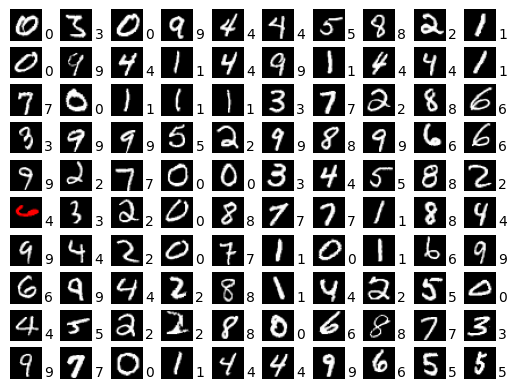

tensor(0.0318, grad_fn=<NllLossBackward0>)
tensor(0.0630, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0073, grad_fn=<NllLossBackward0>)
tensor(0.0602, grad_fn=<NllLossBackward0>)
tensor(0.0329, grad_fn=<NllLossBackward0>)
tensor(0.1577, grad_fn=<NllLossBackward0>)
tensor(0.0061, grad_fn=<NllLossBackward0>)
tensor(0.0312, grad_fn=<NllLossBackward0>)
tensor(0.0083, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0378, Accuracy: 9868/10000 (98.68%)



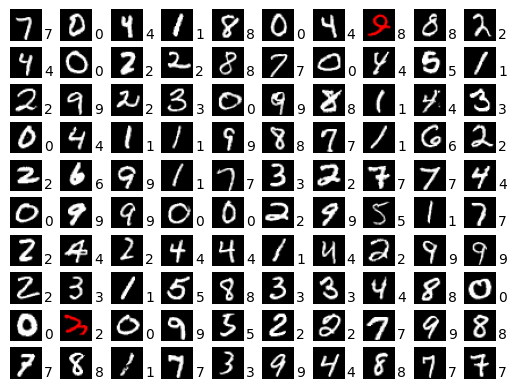

tensor(0.0046, grad_fn=<NllLossBackward0>)
tensor(0.0068, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0105, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0125, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0324, Accuracy: 9903/10000 (99.03%)



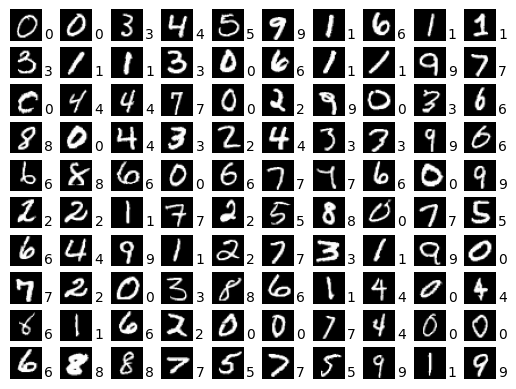

tensor(0.0067, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0051, grad_fn=<NllLossBackward0>)
tensor(0.0204, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0162, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0339, Accuracy: 9910/10000 (99.10%)



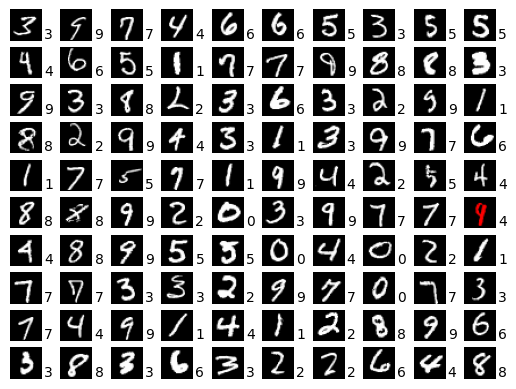

tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.2912, grad_fn=<NllLossBackward0>)
tensor(0.0031, grad_fn=<NllLossBackward0>)
tensor(3.2269e-05, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0371, Accuracy: 9905/10000 (99.05%)



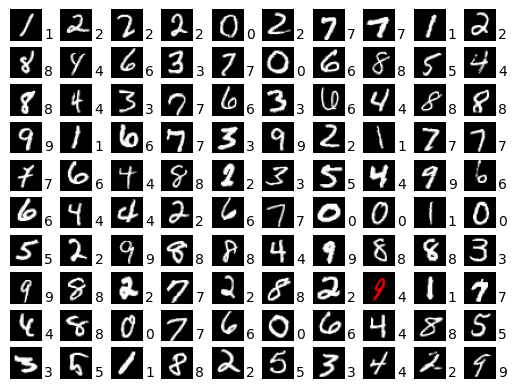

tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(7.6919e-05, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(2.7764e-05, grad_fn=<NllLossBackward0>)
tensor(4.0222e-05, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0375, Accuracy: 9904/10000 (99.04%)



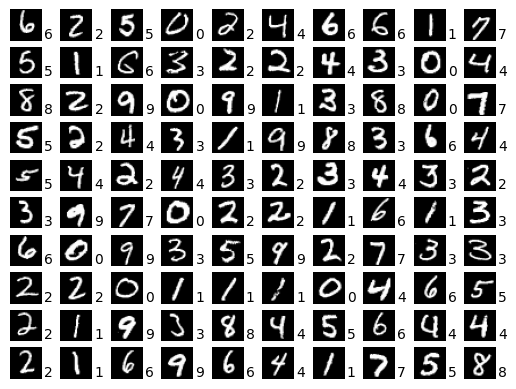

tensor(9.7327e-05, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0072, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(2.3279e-05, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0387, Accuracy: 9905/10000 (99.05%)



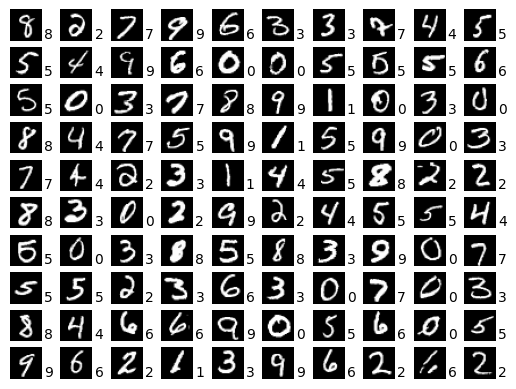

tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(6.8691e-06, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(2.1859e-05, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(6.7134e-05, grad_fn=<NllLossBackward0>)
tensor(6.9667e-05, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0392, Accuracy: 9906/10000 (99.06%)



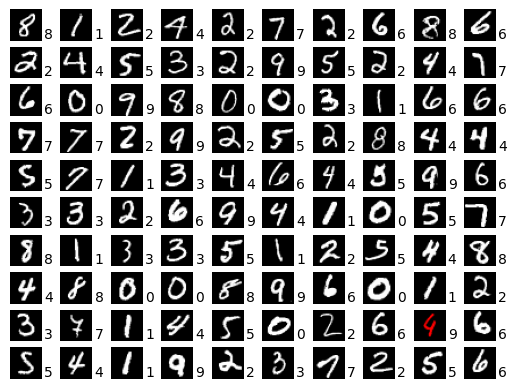

tensor(7.6671e-05, grad_fn=<NllLossBackward0>)
tensor(1.0432e-05, grad_fn=<NllLossBackward0>)
tensor(6.2060e-06, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(6.5545e-05, grad_fn=<NllLossBackward0>)
tensor(8.0774e-05, grad_fn=<NllLossBackward0>)
tensor(2.9066e-05, grad_fn=<NllLossBackward0>)
tensor(6.3816e-05, grad_fn=<NllLossBackward0>)
tensor(0.0001, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0402, Accuracy: 9905/10000 (99.05%)



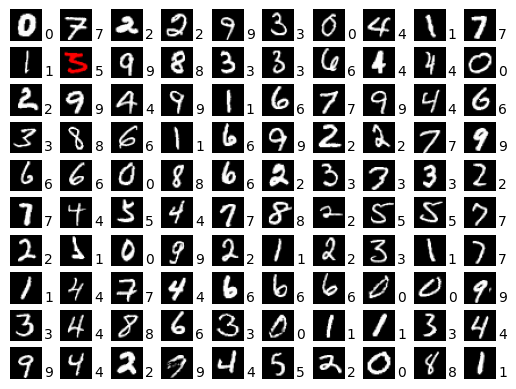

tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(6.8151e-06, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(4.7489e-05, grad_fn=<NllLossBackward0>)
tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0403, Accuracy: 9906/10000 (99.06%)



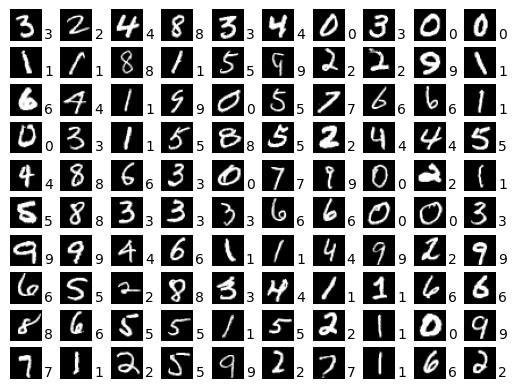

In [14]:
model = ConvNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler

optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint_CNNet1.pt")

/var/folders/c6/t8mdrkg55qn7fgh__gkv7nlc0000gn/T/ipykernel_22059/226679542.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


tensor(2.2444, grad_fn=<NllLossBackward0>)
tensor(0.0886, grad_fn=<NllLossBackward0>)
tensor(0.0475, grad_fn=<NllLossBackward0>)
tensor(0.0925, grad_fn=<NllLossBackward0>)
tensor(0.1410, grad_fn=<NllLossBackward0>)
tensor(0.0142, grad_fn=<NllLossBackward0>)
tensor(0.0351, grad_fn=<NllLossBackward0>)
tensor(0.0072, grad_fn=<NllLossBackward0>)
tensor(0.1101, grad_fn=<NllLossBackward0>)
tensor(0.0263, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0506, Accuracy: 9837/10000 (98.37%)



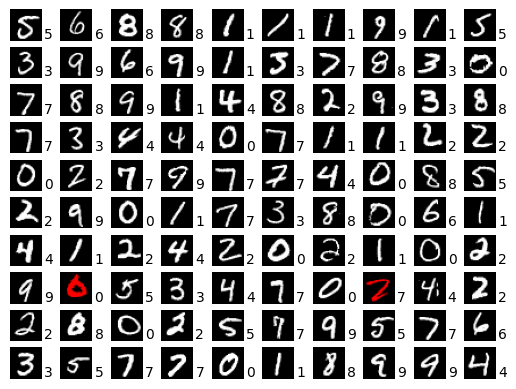

tensor(0.0225, grad_fn=<NllLossBackward0>)
tensor(0.0150, grad_fn=<NllLossBackward0>)
tensor(0.1099, grad_fn=<NllLossBackward0>)
tensor(0.0200, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0099, grad_fn=<NllLossBackward0>)
tensor(0.0133, grad_fn=<NllLossBackward0>)
tensor(0.0732, grad_fn=<NllLossBackward0>)
tensor(0.0198, grad_fn=<NllLossBackward0>)
tensor(0.0369, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0321, Accuracy: 9895/10000 (98.95%)



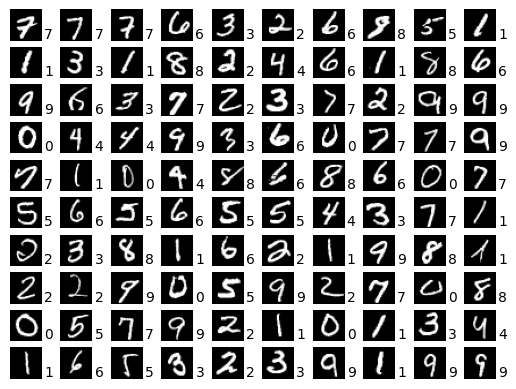

tensor(0.0602, grad_fn=<NllLossBackward0>)
tensor(0.1100, grad_fn=<NllLossBackward0>)
tensor(0.0129, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0108, grad_fn=<NllLossBackward0>)
tensor(0.0051, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0384, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0270, Accuracy: 9914/10000 (99.14%)



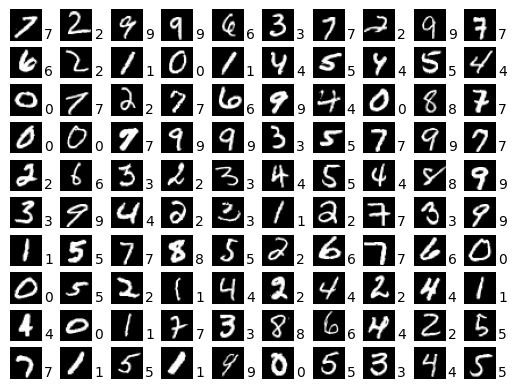

tensor(0.0416, grad_fn=<NllLossBackward0>)
tensor(0.0192, grad_fn=<NllLossBackward0>)
tensor(0.0142, grad_fn=<NllLossBackward0>)
tensor(0.0062, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0189, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0072, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0284, Accuracy: 9903/10000 (99.03%)



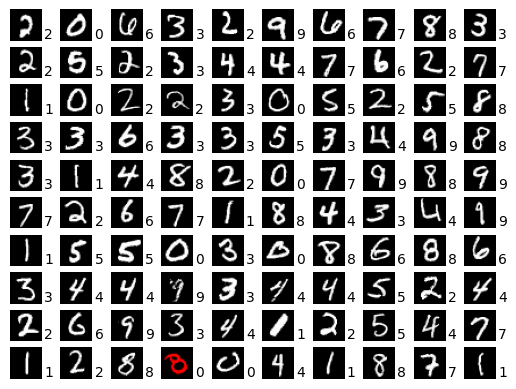

tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0106, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0266, Accuracy: 9912/10000 (99.12%)



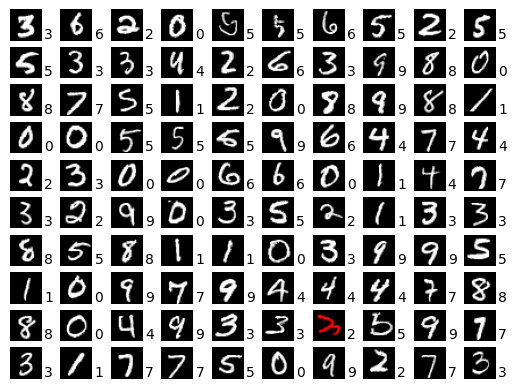

tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0266, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0280, Accuracy: 9907/10000 (99.07%)



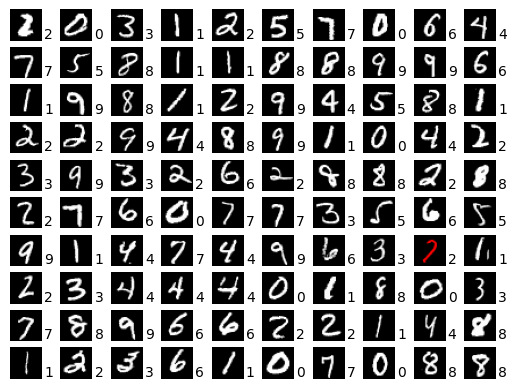

tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0105, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0316, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0277, Accuracy: 9912/10000 (99.12%)



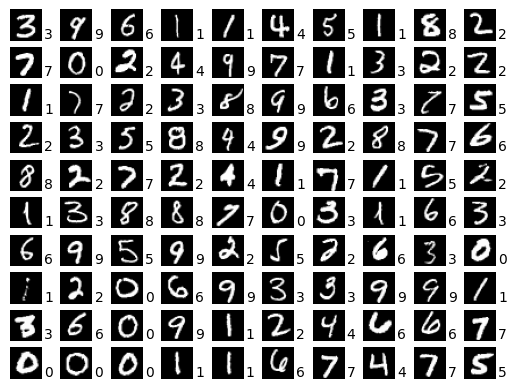

tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0127, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0046, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0274, Accuracy: 9910/10000 (99.10%)



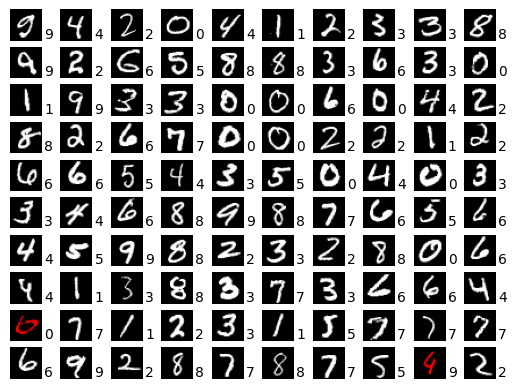

tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0276, Accuracy: 9915/10000 (99.15%)



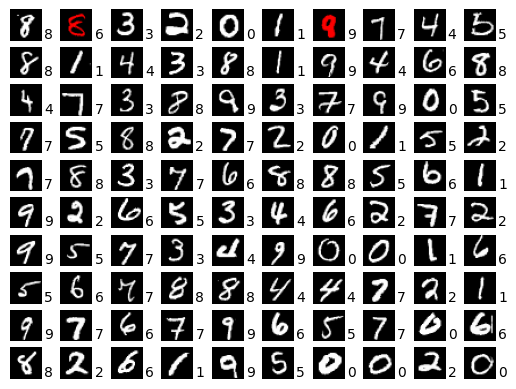

tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0279, Accuracy: 9911/10000 (99.11%)



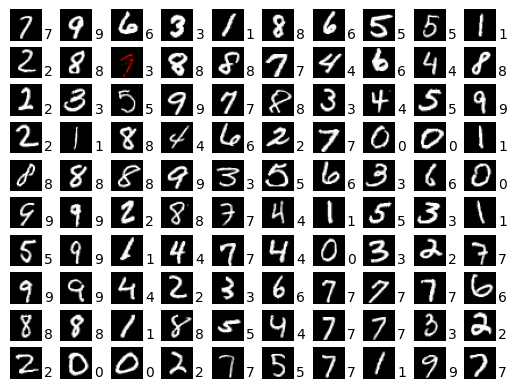

In [15]:
model = ConvNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler

optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint_CNNet2.pt")

/var/folders/c6/t8mdrkg55qn7fgh__gkv7nlc0000gn/T/ipykernel_22059/580884829.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


tensor(2.3491, grad_fn=<NllLossBackward0>)
tensor(0.1654, grad_fn=<NllLossBackward0>)
tensor(0.0377, grad_fn=<NllLossBackward0>)
tensor(0.1091, grad_fn=<NllLossBackward0>)
tensor(0.0857, grad_fn=<NllLossBackward0>)
tensor(0.0510, grad_fn=<NllLossBackward0>)
tensor(0.0249, grad_fn=<NllLossBackward0>)
tensor(0.0336, grad_fn=<NllLossBackward0>)
tensor(0.0221, grad_fn=<NllLossBackward0>)
tensor(0.0085, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0396, Accuracy: 9865/10000 (98.65%)



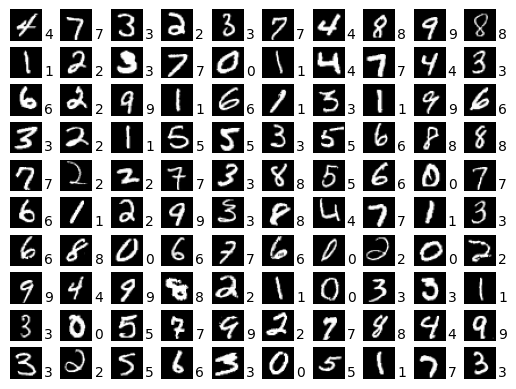

tensor(0.0910, grad_fn=<NllLossBackward0>)
tensor(0.0163, grad_fn=<NllLossBackward0>)
tensor(0.0098, grad_fn=<NllLossBackward0>)
tensor(0.1241, grad_fn=<NllLossBackward0>)
tensor(0.0165, grad_fn=<NllLossBackward0>)
tensor(0.0078, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0176, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0294, Accuracy: 9901/10000 (99.01%)



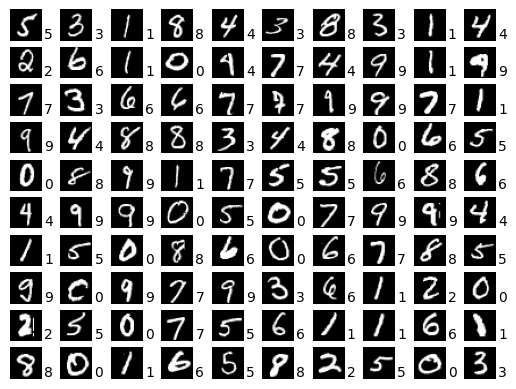

tensor(0.0210, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0318, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0073, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0180, grad_fn=<NllLossBackward0>)
tensor(0.1985, grad_fn=<NllLossBackward0>)
tensor(0.0054, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0252, Accuracy: 9922/10000 (99.22%)



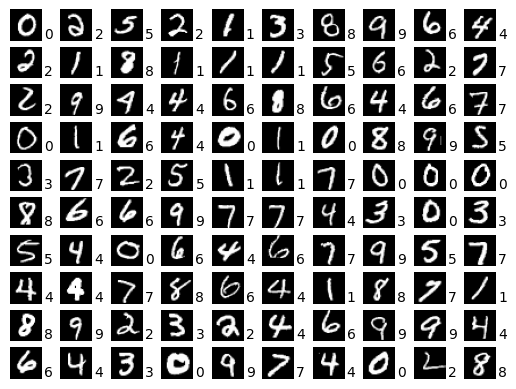

tensor(0.0149, grad_fn=<NllLossBackward0>)
tensor(0.0100, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.0046, grad_fn=<NllLossBackward0>)
tensor(0.0148, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0276, Accuracy: 9911/10000 (99.11%)



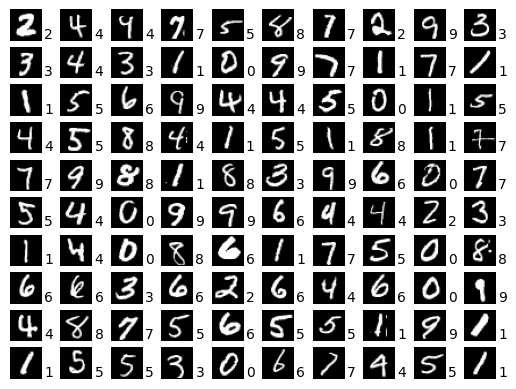

tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0254, Accuracy: 9919/10000 (99.19%)



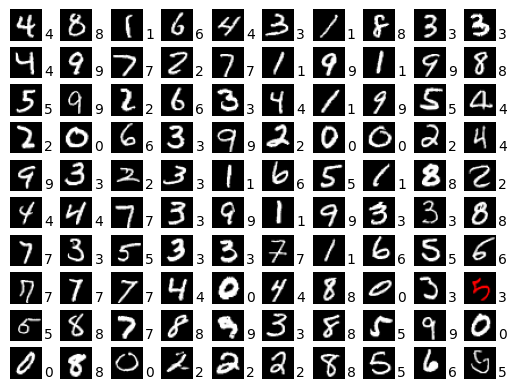

tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0043, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0257, Accuracy: 9920/10000 (99.20%)



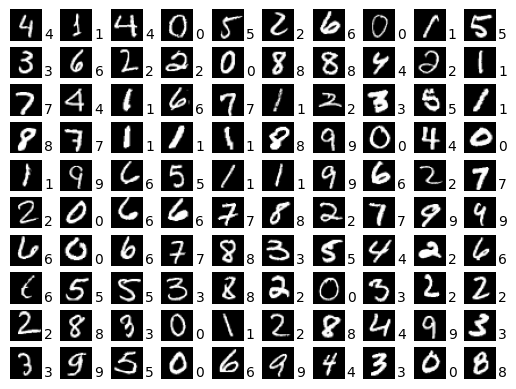

tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0269, Accuracy: 9912/10000 (99.12%)



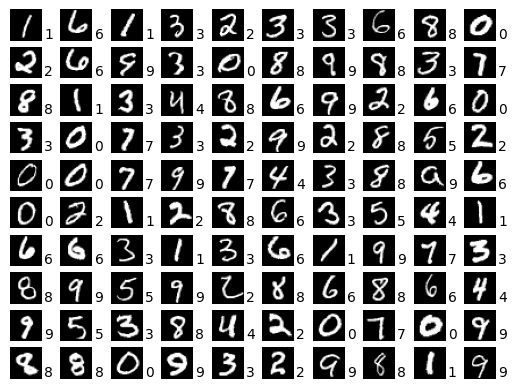

tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(8.5244e-05, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0258, Accuracy: 9911/10000 (99.11%)



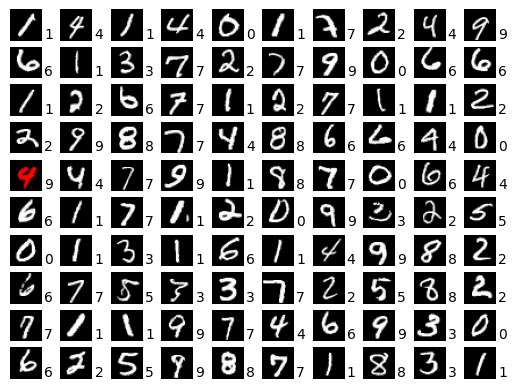

tensor(0.0127, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0265, Accuracy: 9919/10000 (99.19%)



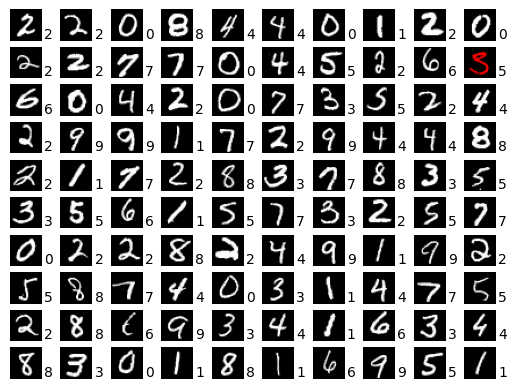

tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0262, Accuracy: 9910/10000 (99.10%)



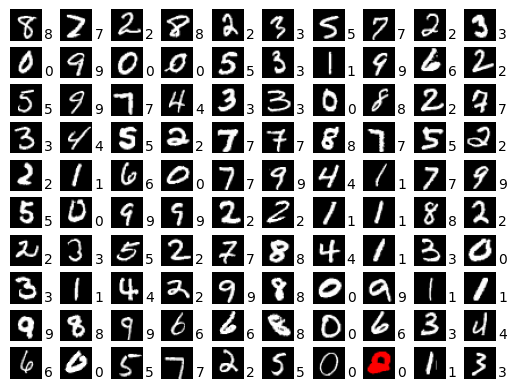

In [16]:
model = ConvNet3()
if use_cuda:
    model = model.cuda()
    
# initialize optimizer and scheduler

optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint_CNNet3.pt")